<a href="https://colab.research.google.com/github/Iallen520/lhy_DL_Hw/blob/master/hw12_domain_adaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 12 - Transfer Learning (Domain Adversarial Training)

> Author: Arvin Liu (b05902127@ntu.edu.tw)

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

# Readme


HW12的任務是Transfer Learning中的Domain Adversarial Training。

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 也就是左下角的那一塊。

## Scenario and Why Domain Adversarial Training
你現在有Source Data + label，其中Source Data和Target Data可能有點關係，所以你想要訓練一個model做在Source Data上並Predict在Target Data上。

但這樣有什麼樣的問題? 相信大家學過Anomaly Detection就會知道，如果有data是在Source Data沒有出現過的(或稱Abnormal的)，那麼model大部分都會因為不熟悉這個data而可能亂做一發。 

以下我們將model拆成Feature Extractor(上半部)和Classifier(下半部)來作例子:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

整個Model在學習Source Data的時候，Feature Extrator因為看過很多次Source Data，所以所抽取出來的Feature可能就頗具意義，例如像圖上的藍色Distribution，已經將圖片分成各個Cluster，所以這個時候Classifier就可以依照這個Cluster去預測結果。

但是在做Target Data的時候，Feature Extractor會沒看過這樣的Data，導致輸出的Target Feature可能不屬於在Source Feature Distribution上，這樣的Feature給Classifier預測結果顯然就不會做得好。

## Domain Adversarial Training of Nerural Networks (DaNN)
基於如此，是不是只要讓Soucre Data和Target Data經過Feature Extractor都在同個Distribution上，就會做得好了呢? 這就是DaNN的主要核心。

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

我們追加一個Domain Classifier，在學習的過程中，讓Domain Classifier去判斷經過Feature Extractor後的Feature是源自於哪個domain，讓Feature Extractor學習如何產生Feature以**騙過**Domain Classifier。 持久下來，通常Feature Extractor都會打贏Domain Classifier。(因為Domain Classifier的Input來自於Feature Extractor，而且對Feature Extractor來說Domain&Classification的任務並沒有衝突。)

如此一來，我們就可以確信不管是哪一個Domain，Feature Extractor都會把它產生在同一個Feature Distribution上。

# Data Introduce

這次的任務是Source Data: 真實照片，Target Data: 手畫塗鴉。

我們必須讓model看過真實照片以及標籤，嘗試去預測手畫塗鴉的標籤為何。

資料位於[這裡](https://drive.google.com/open?id=16p0eoReFvKUq9meLKB7hGEVoDVl_7IaP)，以下的code分別為下載和觀看這次的資料大概長甚麼樣子。

特別注意一點: **這次的source和target data的圖片都是平衡的，你們可以使用這個資訊做其他事情。**

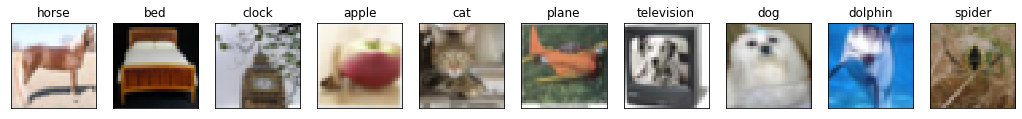

In [2]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, 縮放模式為nearest。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # 不要顯示axis。
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

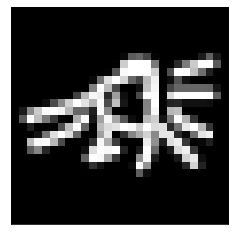

In [20]:
fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/.bmp'))

# Special Domain Knowledge

因為大家塗鴉的時候通常只會畫輪廓，我們可以根據這點將source data做點邊緣偵測處理，讓source data更像target data一點。

## Canny Edge Detection
算法這邊不贅述，只教大家怎麼用。若有興趣歡迎參考wiki或[這裡](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19)。

cv2.Canny使用非常方便，只需要兩個參數: low_threshold, high_threshold。

```cv2.Canny(image, low_threshold, high_threshold)```

簡單來說就是當邊緣值超過high_threshold，我們就確定它是edge。如果只有超過low_threshold，那就先判斷一下再決定是不是edge。

以下我們直接拿source data做做看。

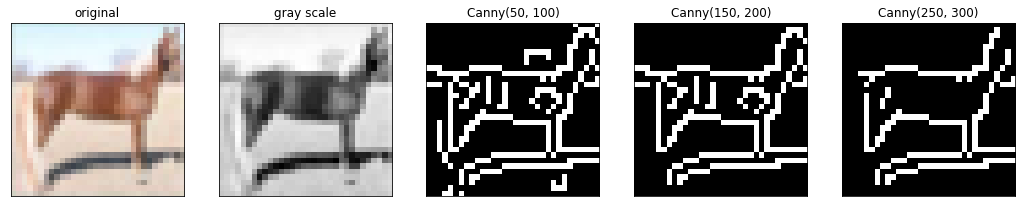

In [7]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')

# Data Process

在這裡我故意將data用成可以使用torchvision.ImageFolder的形式，所以只要使用該函式便可以做出一個datasets。

transform的部分請參考以下註解。

#### 一些細節

在一般的版本上，對灰階圖片使用RandomRotation使用```transforms.RandomRotation(15)```即可。但在colab上需要加上```fill=(0,)```才可運行。
在n98上執行需要把```fill=(0,)```拿掉才可運行。


In [46]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

source_transform = transforms.Compose([
    # 轉灰階: Canny 不吃 RGB。
    transforms.Grayscale(),
    # cv2 不吃 skimage.Image，因此轉成np.array後再做cv2.Canny
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # 重新將np.array 轉回 skimage.Image
    transforms.ToPILImage(),
    # 水平翻轉 (Augmentation)
    transforms.RandomHorizontalFlip(),
    # 旋轉15度內 (Augmentation)，旋轉後空的地方補0
    transforms.RandomRotation(15),
    # 最後轉成Tensor供model使用。
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    transforms.ToPILImage(),
    # 轉灰階: 將輸入3維壓成1維。
    transforms.Grayscale(),
    # 縮放: 因為source data是32x32，我們將target data的28x28放大成32x32。
    transforms.Resize((32, 32)),
    # 水平翻轉 (Augmentation)
    transforms.RandomHorizontalFlip(),
    # 旋轉15度內 (Augmentation)，旋轉後空的地方補0
    transforms.RandomRotation(15),
    # 最後轉成Tensor供model使用。
    transforms.ToTensor(),
])

import os
class TestDataset(torch.utils.data.Dataset):
  def __init__(self, root):
    self.root = root
    self.data = []
    self.transform = target_transform
    filenames = os.listdir(self.root)
    for filename in filenames:
        original_img = plt.imread(os.path.join(self.root, filename))
        self.data.append(self.transform(original_img))
    print (f'test dataset size: {len(self.data)}')

  def __len__(self):
      return len(self.data)

  def __getitem__(self, index):
      return self.data[index]

source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = TestDataset('real_or_drawing/test_data')

source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

test dataset size: 100000


# Model

Feature Extractor: 典型的VGG-like疊法。

Label Predictor / Domain Classifier: MLP到尾。

相信作業寫到這邊大家對以下的Layer都很熟悉，因此不再贅述。

In [47]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):
    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

# Pre-processing

這裡我們選用Adam來當Optimizer。

In [48]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

# Start Training


## 如何實作DaNN?

理論上，在原始paper中是加上Gradient Reversal Layer，並將Feature Extractor / Label Predictor / Domain Classifier 一起train，但其實我們也可以交換的train Domain Classfier & Feature Extractor(就像在train GAN的Generator & Discriminator一樣)，這也是可行的。

在code實現中，我們採取後者的方式，畢竟大家上個作業就是GAN，應該會比較熟悉:)。

## 小提醒
* 原文中的lambda(控制Domain Adversarial Loss的係數)是有Adaptive的版本，如果有興趣可以參考[原文](https://arxiv.org/pdf/1505.07818.pdf)。以下為了方便固定設置0.1。
* 因為我們完全沒有target的label，所以結果如何，只好丟kaggle看看囉:)?

In [50]:
def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: 調控adversarial的loss係數。
    '''
    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    # total_hit: 計算目前對了幾筆 total_num: 目前經過了幾筆
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0

    for i, ((source_data, source_label), target_data) in enumerate(zip(source_dataloader, target_dataloader)):
        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # 我們把source data和target data混在一起，否則batch_norm可能會算錯 (兩邊的data的mean/var不太一樣)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # 設定source data的label為1
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : 訓練Domain Classifier
        feature = feature_extractor(mixed_data)
        # 因為我們在Step 1不需要訓練Feature Extractor，所以把feature detach避免loss backprop上去。
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss += loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : 訓練Feature Extractor和Domain Classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss為原本的class CE - lamb * domain BCE，相減的原因同GAN中的Discriminator中的G loss。
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss += loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

# 訓練200 epochs
for epoch in range(200):
    train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, lamb=0.1)
    torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
    torch.save(label_predictor.state_dict(), f'predictor_model.bin')
    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))

epoch   0: train D loss: 0.6169, train F loss: 1.5282, acc 0.4392
epoch   1: train D loss: 0.5540, train F loss: 1.4088, acc 0.4928
epoch   2: train D loss: 0.5400, train F loss: 1.3517, acc 0.5072
156epoch   3: train D loss: 0.5611, train F loss: 1.2677, acc 0.5408
epoch   4: train D loss: 0.5515, train F loss: 1.2263, acc 0.5518
epoch   5: train D loss: 0.5433, train F loss: 1.1990, acc 0.5584
epoch   6: train D loss: 0.5568, train F loss: 1.1538, acc 0.5838
epoch   7: train D loss: 0.5401, train F loss: 1.1325, acc 0.5972
epoch   8: train D loss: 0.5518, train F loss: 1.0955, acc 0.5988
epoch   9: train D loss: 0.5448, train F loss: 1.0312, acc 0.6216
epoch  10: train D loss: 0.5463, train F loss: 1.0040, acc 0.6370
epoch  11: train D loss: 0.5211, train F loss: 1.0064, acc 0.6316
epoch  12: train D loss: 0.5199, train F loss: 0.9467, acc 0.6570
epoch  13: train D loss: 0.5055, train F loss: 0.9348, acc 0.6550
epoch  14: train D loss: 0.5165, train F loss: 0.8854, acc 0.6716
epoch  

KeyboardInterrupt: 

# Inference

就跟前幾次作業一樣。這裡我使用pd來生產csv，因為看起來比較潮(?)

此外，200 epochs的Accuracy可能會不太穩定，可以多丟幾次或train久一點。

In [51]:
result = []
label_predictor.eval()
feature_extractor.eval()
for i, test_data in enumerate(test_dataloader):
    test_data = test_data.cuda()
    class_logits = label_predictor(feature_extractor(test_data))
    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)

df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)

# Q&A

有任何問題Domain Adaptation的問題可以寄信到b05902127@ntu.edu.tw / ntu-ml-2020spring-ta@googlegroups.com。

時間允許的話我會更新在這裡。

# Special Thanks
這次的作業其實是我出在2019FALL的ML Final Project，以下是我認為在Final Report不錯的幾組，有興趣的話歡迎大家參考看看。

[NTU_r08942071_太神啦 / 組長: 劉正仁同學](https://drive.google.com/open?id=11uNDcz7_eMS8dMQxvnWsbrdguu9k4c-c)

[NTU_r08921a08_CAT / 組長: 廖子毅同學](https://drive.google.com/open?id=1xIkSs8HAShdcfV1E0NEnf4JDbL7POZTf)
